# IMPORTS & CONFIGS 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import os
import glob


# INITIAL DATA PROCESSING

In [19]:
def data_start(dir: str) -> object:
    main_df = pd.DataFrame()
    
    filepaths = glob.glob(os.path.join(dir, "*.csv"))
    
    for files in filepaths:
        df = pd.read_csv(files, sep=';',decimal=',', index_col=False, skiprows=8, usecols=range(18), encoding='iso-8859-1')
        df['datetime'] = pd.to_datetime(df.iloc[:, 0] + ' ' + df.iloc[:, 1])
        # Drop the original date and time columns by index
        df.drop(df.columns[[0, 1]], axis=1, inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        df = df.dropna()
        
        
        df['year_month'] = df['datetime'].dt.to_period('M')
        df.drop(df.columns[[-2]], axis=1, inplace=True)
        
        # Group by year and month and calculate the average of 'x' and 'y'

        monthly_avg = df.groupby('year_month').mean()
        monthly_avg.reset_index(inplace=True)
        monthly_avg['year_month'] = monthly_avg['year_month'].astype(str)
        if len(main_df) == 0:
            main_df = monthly_avg
        else:
            main_df = pd.concat([main_df, monthly_avg])

    
    del df
    del monthly_avg

    return main_df

In [24]:
def plot(df: object) -> None:
    plt.figure(figsize=(100, 6))

    # Plot the 'x' column
    for i in df.columns:
        if i != 'year_month':
            plt.plot(df['year_month'], df[i], linestyle='-', label=i)  

    # Plot the 'y' column
    # plt.plot(df.index, df["TEMPERATURA M�XIMA NA HORA ANT. (AUT) (�C)"], marker='s', linestyle='-', label='y')

    # Adding titles and labels
    plt.title('DATA x YEAR_MOUNTH')
    plt.xlabel('DATA')
    plt.ylabel('YEAR_MOUNTH')

    # Adding a legend
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

# MAIN

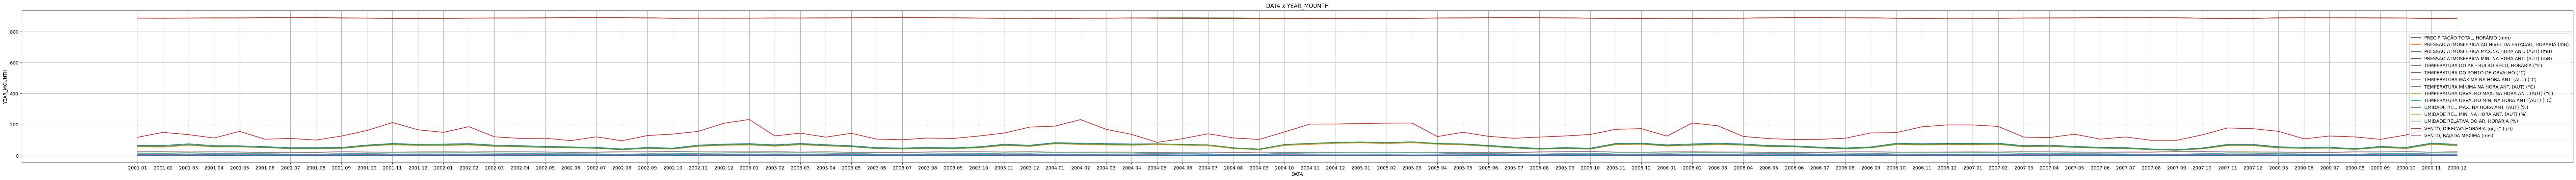

In [31]:
data_dir = "../Data"
data_frame = data_start(data_dir)
data_frame.drop(columns=['RADIACAO GLOBAL (KJ/m²)'], inplace=True)
# display(data_frame)
plot(data_frame)